In [2]:
# Basic operations
import numpy as np
import pandas as pd

# Visualizations
import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Import csv files
df = pd.read_csv("UMW_FR_reduced.csv", sep=",")
imdb = pd.read_csv("IMDB_movies_data_clean.csv", sep=",")
tags = pd.read_csv("tags_clean.csv", sep=",")

D:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (19,20,33,34) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# 1. Tags

In [52]:
# Aggregate by movies
cols = ['original_title', 'royalties_paid_eur']
df_revenue = df[cols].groupby('original_title')['royalties_paid_eur'].sum()
df_count = df[cols].groupby('original_title')['royalties_paid_eur'].count()
df_movies = pd.DataFrame({'revenue':df_revenue, 'count':df_count})

In [53]:
#Get the map between mama ids and original titles
cols = ['mama_movie_id', 'original_title']
id_to_title = df[cols].drop_duplicates().set_index('original_title')
id_to_title = id_to_title.dropna()
id_to_title['mama_movie_id'] = id_to_title['mama_movie_id'].astype(int)

In [54]:
#Join all the tables together
df_movies = df_movies.join(id_to_title)
df_movies = df_movies.merge(tags, left_on='mama_movie_id', right_on='id')

In [98]:
#Median revenue for each tag
data = df_movies.iloc[:, 4:].apply(lambda x:np.median(df_movies['revenue'][x>0]))
data_count = df_movies.iloc[:, 4:].apply(lambda x:len(x[x>0]))
data = pd.DataFrame({'revenue':data, 'count':data_count})
data = data.sort_values('revenue',ascending=False)
data = data.dropna()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text xticklabel objects>)

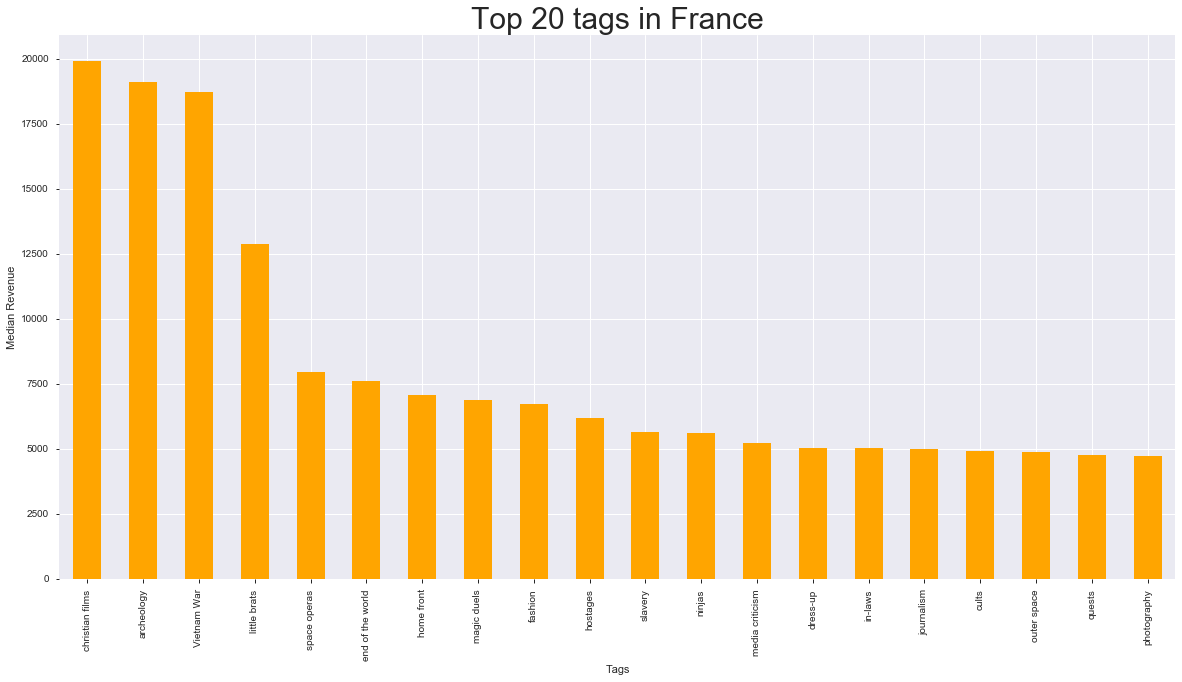

In [111]:
#Top 20 tags
data['revenue'][:20].plot.bar(color = 'orange', figsize = (20, 10))
plt.title('Top 20 tags in France', fontsize = 30, fontweight = 20)
plt.xlabel('Tags')
plt.ylabel('Median Revenue')
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text xticklabel objects>)

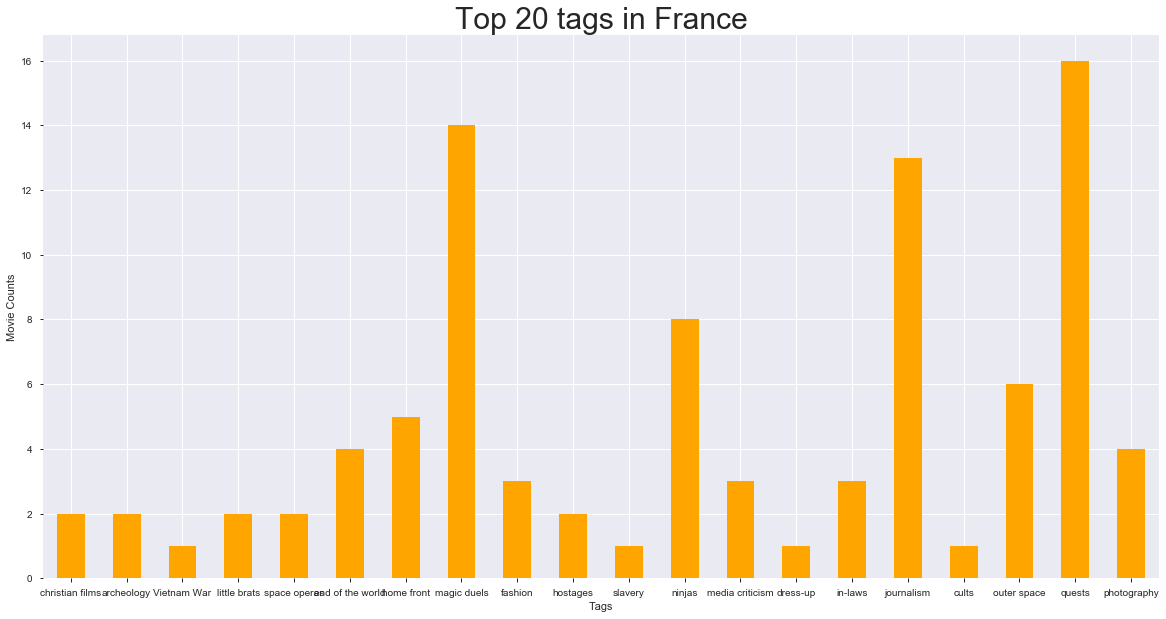

In [107]:
# Corresponding movie counts (if a tag appears only once then its median revenue is probably not reliable)
data['count'][:20].plot.bar(color = 'orange', figsize = (20, 10))
plt.title('Top 20 tags in France', fontsize = 30, fontweight = 20)
plt.xlabel('Tags')
plt.ylabel('Movie Counts')
plt.xticks(rotation=0)

# 2. Transcational Data

In [4]:
df = pd.read_csv("UMW_FR_reduced.csv", sep=",", parse_dates=['date_value'], index_col=['date_value'])

D:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning:

Columns (19,20,33,34) have mixed types. Specify dtype option on import or set low_memory=False.



In [5]:
#Revenue by movie
data = df.groupby('original_title')['royalties_paid_eur'].sum().sort_values()
data

original_title
Dead crossroads - S02E02 - Pris dans la toile        0.830000
Stonados                                             1.160000
Deepfrozen                                           1.240000
Back in Trouble                                      1.240000
Lo mejor de Eva                                      1.240000
                                                     ...     
Astérix et Cléopâtre                             28189.230000
Playing it Cool                                  33621.100000
Les douze travaux d'Astérix                      35845.460000
The Hunters (2013)                               37279.350000
The Escort                                       46288.797205
Name: royalties_paid_eur, Length: 1330, dtype: float64

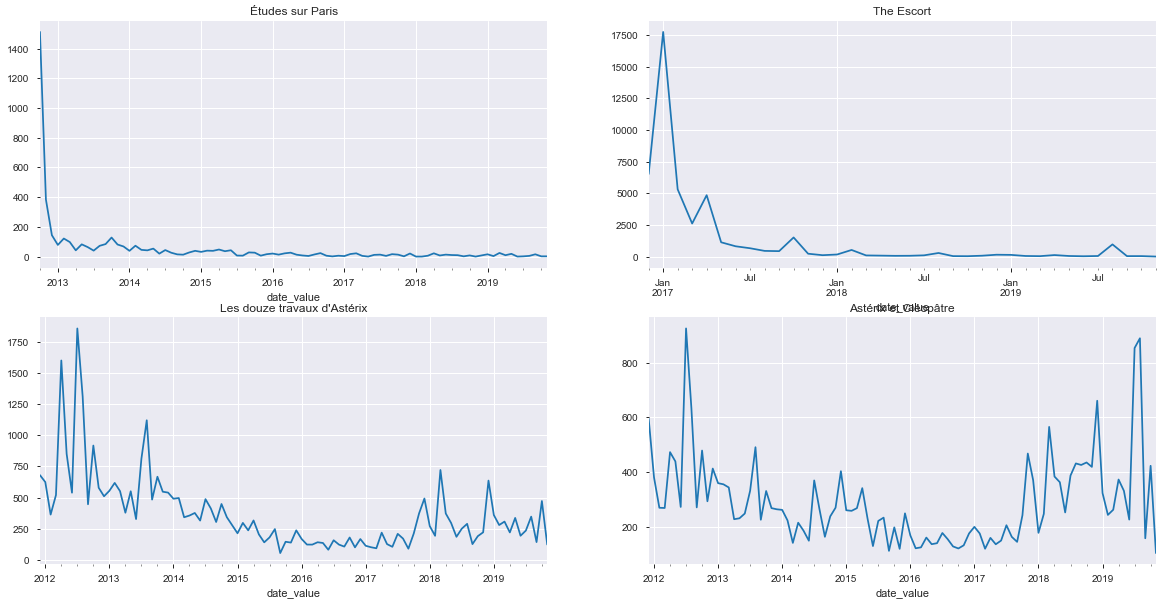

In [49]:
#Revenue by time for four random chosen movies - we may need to find a metric to do the clustering

movies = ['Études sur Paris', 'The Escort', "Les douze travaux d'Astérix", 'Astérix et Cléopâtre']

fig, axes = plt.subplots(2, 2, figsize=(20, 20))
axes = axes.ravel()
for i in range(len(movies)):
    axes[i].set_title(movies[i])
    mask = df['original_title'] == movies[i]
    data = df[mask].resample('1M')['royalties_paid_eur'].sum()
    data.plot.line(figsize = (20, 10), ax=axes[i])

In [63]:
from fbprophet import Prophet

In [64]:
mask = df['original_title'] == "Astérix et Cléopâtre"
data = df[mask].resample('1M')['royalties_paid_eur'].sum()
data = data.reset_index()
data.columns = ['ds', 'y']

In [65]:
model = Prophet(seasonality_mode='multiplicative')

In [66]:
model.fit(data)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [67]:
future = model.make_future_dataframe(periods = 12, freq = 'M')
forecast = model.predict(future)

In [68]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2011-12-31,408.674639,518.427615,764.701617,408.674639,408.674639,0.568157,0.568157,0.568157,0.568157,0.568157,0.568157,0.0,0.0,0.0,640.865888
1,2012-01-31,403.861911,183.217519,427.653670,403.861911,403.861911,-0.240363,-0.240363,-0.240363,-0.240363,-0.240363,-0.240363,0.0,0.0,0.0,306.788530
2,2012-02-29,399.359682,160.373630,408.334015,399.359682,399.359682,-0.295813,-0.295813,-0.295813,-0.295813,-0.295813,-0.295813,0.0,0.0,0.0,281.223946
3,2012-03-31,394.546954,206.818106,441.141562,394.546954,394.546954,-0.179549,-0.179549,-0.179549,-0.179549,-0.179549,-0.179549,0.0,0.0,0.0,323.706400
4,2012-04-30,389.889475,260.137654,495.960314,389.889475,389.889475,-0.024237,-0.024237,-0.024237,-0.024237,-0.024237,-0.024237,0.0,0.0,0.0,380.439910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,2020-07-31,500.917677,698.213886,948.737497,495.377954,506.178586,0.651141,0.651141,0.651141,0.651141,0.651141,0.651141,0.0,0.0,0.0,827.085634
104,2020-08-31,508.385248,513.838832,761.755383,501.650583,514.782694,0.267445,0.267445,0.267445,0.267445,0.267445,0.267445,0.0,0.0,0.0,644.350130
105,2020-09-30,515.611928,238.872827,474.331265,507.825741,523.191853,-0.317089,-0.317089,-0.317089,-0.317089,-0.317089,-0.317089,0.0,0.0,0.0,352.117289
106,2020-10-31,523.079498,450.610019,688.312460,514.170247,531.958750,0.087479,0.087479,0.087479,0.087479,0.087479,0.087479,0.0,0.0,0.0,568.837782


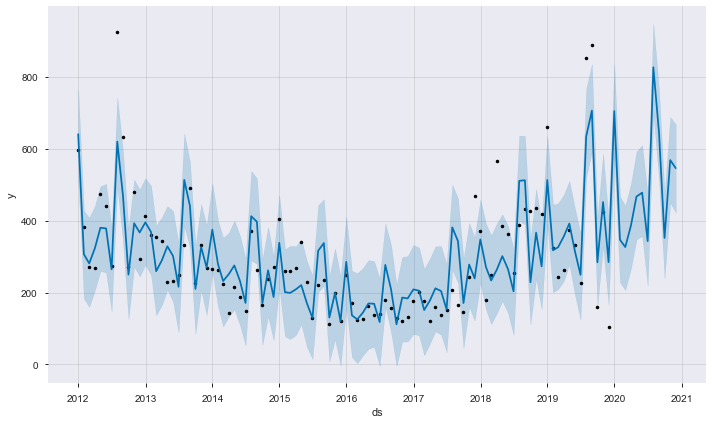

In [69]:
fig = model.plot(forecast)